In [1]:
# Parameters
artificial_humans = "../../model/artificial_humans/01_rnn_edge_features/rnn_True__edge_True__global_features_False.pt"
artificial_humans_model = "graph"
managers = {
    "humanlike_governor": {
        "type": "human",
        "path": "../../artifacts/human_like_manager/04_features/model/prev_punishments_True__prev_manager_valid_True__round_n_False.pt",
    },
    "ai_governor": {
        "type": "rl",
        "path": "../../artifacts/manager_v3/19_rerun/model/model.pt",
    },
}
output_path = "../../data/manager/simulate_rule/v1_comp/"
n_episode_steps = 16
n_episodes = 10


In [2]:
import re
import requests
import datetime
import os
import random
import numpy as np


BACKEND_URL = os.environ.get('MANAGER_BACKEND_URL', 'http://localhost:8000')


def get_punishments(contributions, missing_inputs, groups, *, session, group_idx, round):
    """
    Requests the punishments form the manger backend.

    Args:
        contributions [int]: contributions in fixed order (order has to remain throughout the game)
        missing_inputs [boolean]: missing_inputs in fixed order (same order as contributions)
        groups [str]: group identifier in fixed order (same order as contributions)
        session str: session indentifier
        subsession str: subsession identifier
        round int: round number

    Returns:
        [int]: punishments for each player in the same order then contributions
    """
    data = {
        'contributions': contributions,
        'missing_inputs': missing_inputs,
        'groups': groups,
        'round': round,
        'group_idx': group_idx,
        'session': session,
        'datetime': str(datetime.datetime.now())
    }
    url = BACKEND_URL + '/get_punishments'
    # response = requests.post(url, json={'data': data}).json()
    # return response
    return {'data': {**data, 'punishments': [0]*len(contributions)}}


In [3]:
%load_ext autoreload
%autoreload 2

import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory import Memory
from aimanager.manager.environment_v3 import ArtificialHumanEnv
from aimanager.artificial_humans import GraphNetwork
from aimanager.manager.manager import ArtificalManager

from aimanager.utils.array_to_df import using_multiindex, add_labels

from aimanager.manager.api_manager import MultiManager


output_path = os.path.join(output_path, 'data')

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
device = th.device('cpu')
rec_device = th.device('cpu')
artifical_humans = GraphNetwork.load(artificial_humans, device=device)

groups = ['humanlike_governor'] * 4 + ['ai_governor'] * 4
is_hm = th.tensor([g == 'humanlike_governor' for g in groups])
n_agents = len(groups)

env = ArtificialHumanEnv(
    artifical_humans=artifical_humans, n_agents=n_agents, n_contributions=21, n_punishments=31, 
    n_rounds=n_episode_steps, batch_size=1, device=device)
hm = GraphNetwork.load(managers['humanlike_governor']['path'], device=device)
om = ArtificalManager.load(managers['ai_governor']['path'], device=th.device('cpu')).policy_model

mm = MultiManager(managers)


session = str(random.randint(0, 1000000))
missing_inputs = [False] * n_agents

recorder = Memory(n_episodes=n_episodes, n_episode_steps=n_episode_steps, output_file=None, device=device)

for e in range(n_episodes):
    # if not e%(n_episodes//20):
    #     print(f"episode {e}")

    state = env.reset()

    rounds = []
    for round_number in count():

        contributions = state['contributions'].squeeze().tolist()
        response = get_punishments(
            contributions, missing_inputs, groups, session=session, group_idx=e, round=round_number)
        round = {**response['data'], 'manager_missing_inputs': [False]*n_agents}
        b_action = th.tensor(response['data']['punishments'], dtype=th.int64).unsqueeze(-1)

        c_action = mm.get_punishments(rounds+[round])[0]
        rounds.append({**round, 'punishments': c_action})
        c_action = th.tensor(c_action, dtype=th.int64)

        _state = {**state, **env.get_batch_structure()}
        encoded_hm = hm.encode_pure(_state)
        encoded_om = om.encode_pure(_state)

        action_hm, proba = hm.predict_pure(encoded_hm, reset_rnn=round_number == 0, sample=True)

        action_om, proba = om.predict_pure(encoded_om, reset_rnn=round_number == 0, sample=False)
        action = th.where(is_hm.unsqueeze(-1), action_hm, action_om)

        state = env.punish(action)

        recorder.add(
            **{k: v.squeeze(-1) for k, v in state.items()}, 
            control_punishment=action.squeeze(-1), 
            repro_punishment=c_action,
            episode_step=round_number)
        state, reward, done = env.step()
        if done:
            break
    recorder.next_episode(e)

In [5]:
columns = ['episode', 'round_number','participant_code']

punishments = using_multiindex(recorder.memory['punishments'].numpy(), columns=columns, value_name='punishment')
control_punishment = using_multiindex(recorder.memory['control_punishment'].numpy(), columns=columns, value_name='control_punishment')
repro_punishment = using_multiindex(recorder.memory['repro_punishment'].numpy(), columns=columns, value_name='repro_punishment')
common_good = using_multiindex(recorder.memory['common_good'].numpy(), columns=columns, value_name='common_good')
contributions = using_multiindex(recorder.memory['contributions'].numpy(), columns=columns, value_name='contribution')

df_sim = punishments.merge(common_good).merge(contributions).merge(control_punishment).merge(repro_punishment)
df_sim['p_diff_control'] = df_sim['punishment'] - df_sim['control_punishment']
df_sim['p_diff_repro'] = df_sim['punishment'] - df_sim['repro_punishment']

df_sim['data_source'] = 'simulation'

columns = ['round_number', 'common_good', 'contribution', 'participant_code', 'punishment', 'data_source']

df_sim['group'] = df_sim['participant_code'].map({k:v for k,v in enumerate(groups)})


df = pd.concat([df_sim]).reset_index(drop=True)

dfm = df.melt(
    id_vars=['round_number', 'participant_code', 'data_source', 'group'], 
    value_vars=['punishment', 'contribution', 'p_diff_control', 'p_diff_repro', 'control_punishment'])

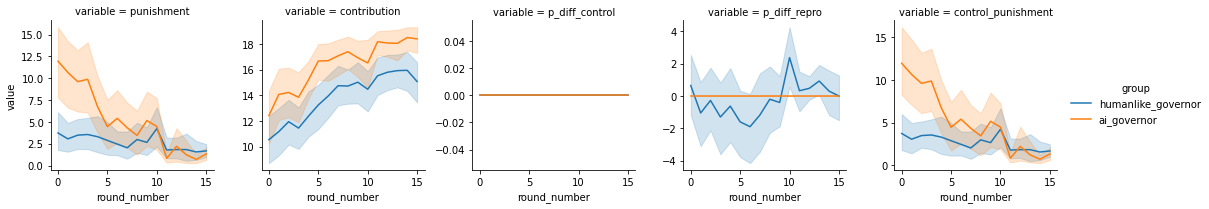

In [6]:
g = sns.relplot(
    data=dfm,
    x="round_number", 
    y="value",
    hue='group',
    col='variable',
    kind="line",
    height=3, aspect=1, facet_kws={'sharey': False, 'sharex': True}
)

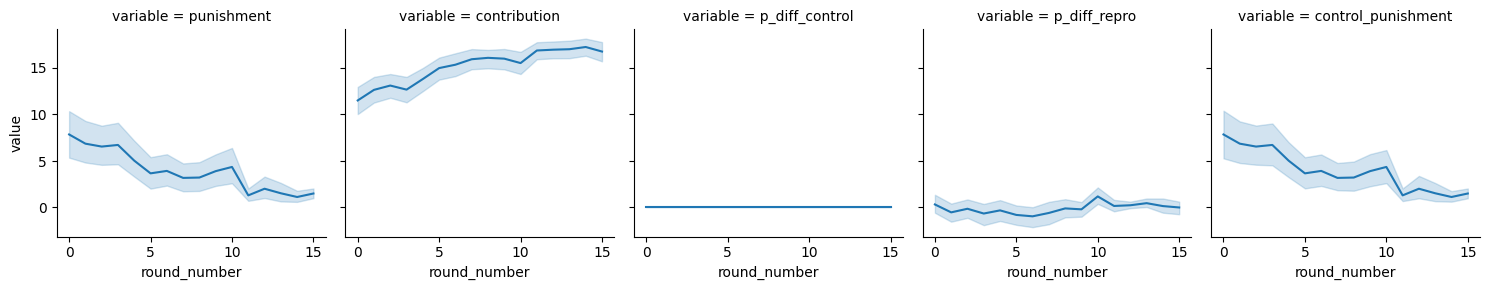

In [7]:
g = sns.relplot(
    data=dfm,
    x="round_number", 
    y="value",
    col='variable',
    kind="line",
    height=3, aspect=1,
)